# Introduction to Neural Networks with TensorFlow and Keras

En este notebook vamos a utilizar una red neuronal para clasificar imágenes de prendas de ropa. Para ello, utilizaremos _Keras_ con _TensorFlow_.

<div style="text-align:center"><img src="https://github.com/zalandoresearch/fashion-mnist/raw/master/doc/img/fashion-mnist-sprite.png" height=400px></div>

El dataset a utilizar es Fashion MNIST, un problema sencillo con imágenes pequeñas de ropa, pero más interesante que el dataset de MNIST. Puedes consultar más información sobre el dataset en [este enlace](https://github.com/zalandoresearch/fashion-mnist).
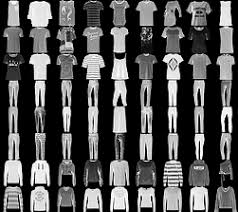

In [1]:
import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf

import matplotlib.pyplot as plt

Using plaidml.keras.backend backend.


Primero, vamos a obtener los datos. Por suerte para nosotros, estos pueden ser descargados directamente desde Keras, por lo que no tendremos que preocuparnos de tratar con ficheros.

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

Acto seguido, normalizamos esos datos de manera similar a como hemos visto con MNIST, obteniendo valores entre 0 y 1. Este paso es muy importante para el correcto funcionamiento de nuestra red.

In [3]:
x_train = x_train / 255.0
x_test = x_test / 255.0

## 1. Información sobre el dataset

Una vez tenemos los datos cargados en memoria, vamos a obtener información sobre los mismos.

In [4]:
# Número de imágenes de entrenamiento
print("Dimensiones del set de entrenamiento:", x_train.shape)

# Número de imágenes de validación
print("Dimensiones del set de validación:", x_test.shape)

Dimensiones del set de entrenamiento: (60000, 28, 28)
Dimensiones del set de validación: (10000, 28, 28)


* Puede verse que el conjunto de entrenamiento dispone de `60.000` elementos con dimensión `28x28`.
* De igual modo se ha obtenido el número de elementos del conjunto de validación que consta de `10.000` imágenes del mismo tamaño.

Esto concuerda con la documentación oficial de Keras para el [dataset fashion-mnist](https://keras.io/datasets/#fashion-mnist-database-of-fashion-articles).

Cada una de las muestras del dataset (tanto de entrenamiento como de validación) contiene una matriz de tamaño `28x28`. Esto se asocia con una imagen de `28x28` píxeles.

El contenido de cada uno de los píxeles es un valor de `0.0` a `1.0` dado que han sido normalizados al dividirse por el máximo: `255`.

Esta escala de valores representa una escala de grises donde `0.0` es el color negro y `1.0` es el blanco.

- Dimensiones de una imagen: 28x28
- Rango de valores de una imagen: [0.0, 1.0]


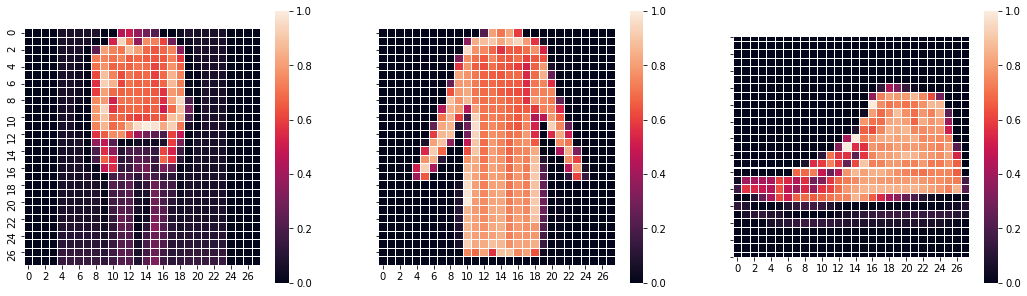

In [5]:
import seaborn as sns
import numpy as np
from random import randint

# Dimensiones de una imagen
n_filas = x_train[0].shape[0]
n_columnas = x_train[0].shape[1]

print("- Dimensiones de una imagen: {}x{}".format(n_filas, n_columnas))
print("- Rango de valores de una imagen: [{}, {}]".format(np.amin(x_train[0]), np.amax(x_train[0])))

# Parámetros generales para la representación de imágenes
n_imagenes_mostrar = 3
ancho_imagen = 6
alto_imagen = 5

f, axes = plt.subplots(1, n_imagenes_mostrar,
                       figsize=(n_imagenes_mostrar * ancho_imagen, alto_imagen),
                       sharey=True)

for ax in axes.flat:
    i_imagen = randint(0, len(x_train) - 1)
    sns.heatmap(x_train[i_imagen], linewidths=.01, square=True, ax=ax)

Si se analiza ahora la variable objetivo, puede verse que en total hay `10` clases posibles de clasificación.

Estas clases están codificadas con un valor de `0` a `9`.

In [6]:
clases = set(y_train)
n_clases = len(clases)

print("Número total de clases:", n_clases)
print("Clases:", clases)

Número total de clases: 10
Clases: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


De acuerdo con la [documentación oficial](https://github.com/zalandoresearch/fashion-mnist#labels) del set de datos, estas categorías son:

| Label | Description ||| Label | Description |
| --- | --- |-| --- | --- |
| 0 | T-shirt/top ||| 5 | Sandal |
| 1 | Trouser ||| 6 | Shirt |
| 2 | Pullover ||| 7 | Sneaker |
| 3 | Dress ||| 8 | Bag |
| 4 | Coat ||| 9 | Ankle boot |

In [7]:
clases = (
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
)

Vamos a **visualizar** una imagen de ejemplo. Prueba tu mismo a cambiar la imagen en uso para explorar el dataset visualmente ejecutando el siguiente código:

In [8]:
def visualize_example(x):
    plt.figure()
    plt.imshow(x)
    plt.colorbar()
    plt.grid(False)
    plt.show()

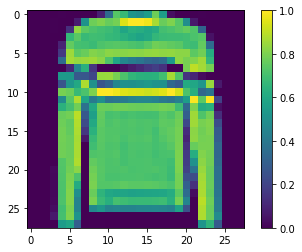

In [9]:
visualize_example(x_train[5])

## 2. Entrenamiento de una red neuronal simple

#### Preparación de datos

Antes de crear el modelo y entrenarlo, el primer paso será adaptar los datos que se proporcionarán al modelo para que éste pueda trabajar con ellos.

Para ello las variables objetivo se convertirán en variables categóricas pasando de ser un único valor de `0` a `9` por registro, a un vector de 10 elementos donde todos los elementos serán `0` excepto el elemento de la posición correspondiente al valor de dicho registro que será `1`.

Ejemplo de categorización de la clase `3: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]`

In [10]:
# Tratamiendo de los datos para keras
y_train = keras.utils.to_categorical(y_train, num_classes=n_clases)
y_test = keras.utils.to_categorical(y_test, num_classes=n_clases)

#### Composición del modelo

Ahora se procede a crear un modelo `Sequential` con una primera capa que será la capa de entrada y que será de tipo `Dense` o *densely-connected NN*, con tamaño `128`, función de activación `activation='sigmoid'` y recibirá imágenes de `28x28` elementos, `input_shape=(28,28)`.

Tras esta capa se añade otra de tipo `Dropout` cuya misión es evitar el sobreajuste estableciendo a `0` aleatoriamente algunos elementos en la entrada de la siguiente capa.

Posteriormente se añade otra capa de tipo `Dense`, esta vez de tamaño `64` con el mismo tipo de función de *activación*.

Nuevamente se añade otra capa de tipo `Dropout` con el fin de prevenir sobreajustes.

Antes de la capa de salida se añade una última capa oculta de tipo `Flatten` que como su nombre indica aplana la salida de la capa anterior para convertirla en un vector unidimensional.

Finalmente se añade una última capa de tipo `Dense` de tamaño `10` dado que es el número de categorías en el que clasificar las imágenes y con función de activación `softmax`.

In [11]:
from keras.layers import Dropout, Flatten
from keras.optimizers import SGD

model = Sequential()

# Capa de entrada y primera capa oculta
model.add(Dense(128, activation='sigmoid', input_shape=(n_filas, n_columnas)))

# Capas ocultas
model.add(Dropout(0.5))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.5))

# Se añade esta capa adicional para que la salida de la capa anterior
# que devolvía un array de 2 dimensiones se aplane 
model.add(Flatten())

# Capa de salida
model.add(Dense(n_clases, activation='softmax'))

INFO:plaidml:Opening device "metal_amd_radeon_hd_-_firepro_d700.1"


#### Compilación del modelo

Antes de compilar el modelo se crea un optimizador, `sgd`, de tipo *stochastic gradient descent* que se le proporcionará al modelo en el momento de la compilación.

Como función de coste se usará la función `categorical_crossentropy` y como métrica de evaluación durante el entramiento se usará la métrica `accuracy`.

In [12]:
# Optimizador
sgd = SGD(
    lr=0.01,      # tasa de aprendizaje
    momentum=0.9  # acelera SGD en la dirección correcta
)

# Compilación del modelo
model.compile(
    optimizer=sgd,                     # también podría ser 'sgd' que crearía un SGD con los valores por defecto
    loss='categorical_crossentropy',   # función de coste para variables categóricas: https://keras.io/losses/
    metrics=['accuracy']               # métrica de evaluación durante el entrenamiento
)

# Se muestra un resumen del modelo
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 28, 128)           3712      
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 128)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 28, 64)            8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 28, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1792)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                17930     
Total params: 29,898
Trainable params: 29,898
Non-trainable params: 0
_________________________________________________________________


#### Entrenamiento del modelo

Por último, se entrena el modelo con la función `fit` a la cuál se le indica que se quiere entrenar en `20` *épocas* y con *batches* de `64` muestras.

In [13]:
# Entrenamiento del modelo
n_epocs = 20
batch_size = 64

model.fit(x_train, y_train, epochs=n_epocs, batch_size=batch_size)

Epoch 1/20
60000/60000 [==============================] - 7s 121us/step - loss: 1.4245 - acc: 0.4852
Epoch 2/20
60000/60000 [==============================] - 7s 119us/step - loss: 0.8075 - acc: 0.7071
Epoch 3/20
60000/60000 [==============================] - 7s 119us/step - loss: 0.7060 - acc: 0.7423
Epoch 4/20
60000/60000 [==============================] - 7s 119us/step - loss: 0.6575 - acc: 0.7601
Epoch 5/20
60000/60000 [==============================] - 7s 119us/step - loss: 0.6232 - acc: 0.7704
Epoch 6/20
60000/60000 [==============================] - 7s 119us/step - loss: 0.5983 - acc: 0.7802
Epoch 7/20
60000/60000 [==============================] - 7s 118us/step - loss: 0.5798 - acc: 0.7883
Epoch 8/20
60000/60000 [==============================] - 7s 119us/step - loss: 0.5681 - acc: 0.7910
Epoch 9/20
60000/60000 [==============================] - 7s 118us/step - loss: 0.5578 - acc: 0.7947
Epoch 10/20
60000/60000 [==============================] - 7s 119us/step - loss: 0.5457 - a

## 3. Evaluación del modelo en datos de test

Una vez hemos entrenado nuestro modelo, vamos a evaluarlo en los datos de test de Fashion MNIST.

Para evaluar el modelo con los datos de test se usa la función `evaluate` del modelo.

In [14]:
loss, accuracy = model.evaluate(x_test, y_test, batch_size=batch_size)

print("- loss: {:.2f}%".format(loss * 100))
print("- accuraty: {:.2f}%".format(accuracy * 100))

10000/10000 [==============================] - 1s 71us/step
- loss: 45.62%
- accuraty: 83.75%


La precisión obtenida con los datos de test está entorno al `84%` con un *loss* del `45%`.

Al establecer la función `softmax` como función de activación de la capa de salida, los resultados para cada una de las muestras están normalizados para que la suma de cada vector de categorías sume `1`.

Por tanto, para interpretar correctamente la predicción, habrá que tomar el mayor valor del array. Su posición en el array determinará la categoría a la que se predice que pertenece esa muestra.

1. La imagen 4375 se ha clasificado como 'Ankle boot' → ✅
2. La imagen 7944 se ha clasificado como 'Coat' → ✅
3. La imagen 5335 se ha clasificado como 'Bag' → ✅


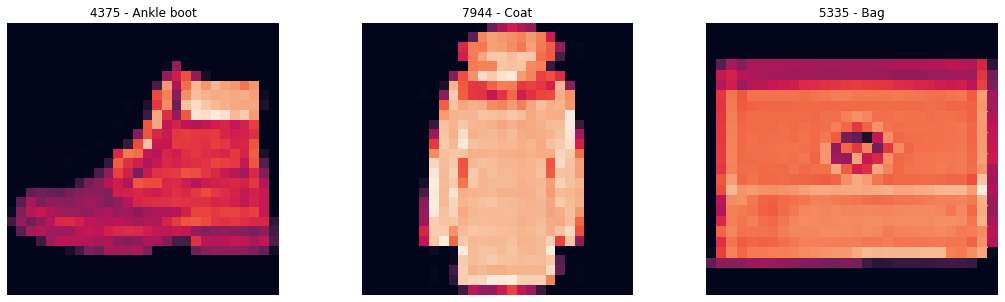

In [15]:
# Predicciones a partir del conjunto de test
y_pred = model.predict(x_test, batch_size=batch_size)

# Análisis de algunos resultados
imagenes_seleccionadas = []
clases_predichas = []

for it in range(0, n_imagenes_mostrar):
    
    # Selección aleatoria de una muestra
    i_imagen = randint(0, len(y_pred) - 1)
    imagenes_seleccionadas.append(i_imagen)
    
    # Obtención de la clase predicha
    pred = y_pred[i_imagen]
    cat_pred = list(pred).index(max(pred))
    
    clase = clases[cat_pred]
    clases_predichas.append(clase)
    
    # Obtención de la clase real
    cat_real = list(y_test[i_imagen]).index(1)
    
    # Información sobre el resultado
    print("{pos}. La imagen {img} se ha clasificado como '{pred}' → {ok}".format(
        pos=it+1,
        img=i_imagen,
        pred=clase,
        ok='✅' if cat_pred == cat_real else "❌ Se esperaba '{}'".format(clases[cat_real])
    ))

# Representación de las muestras seleccionadas
f, axes = plt.subplots(1, n_imagenes_mostrar,
                       figsize=(n_imagenes_mostrar * ancho_imagen, alto_imagen),
                       sharey=True)

for ax, i_imagen, clase in zip(axes.flat, imagenes_seleccionadas, clases_predichas):
    sns.heatmap(x_test[i_imagen], square=True, ax=ax, cbar=False)
    ax.set_title("{img} - {cat}".format(img=i_imagen, cat=clase))
    ax.tick_params(axis='both', which='both',
                   bottom=False, labelbottom=False,
                   left=False, labelleft=False)